In [3]:
# Cell 1: installs & imports (run once)
!pip install -q plotly tqdm

import numpy as np
import random
from collections import defaultdict
import plotly.graph_objects as go
import plotly.express as px
from tqdm import trange
import time
import math
import matplotlib.pyplot as plt
import pandas as pd

# make plots look consistent in notebooks
plt.style.use('seaborn-v0_8-darkgrid')



In [4]:
# Cell 2: Choose flood behavior and global experiment settings
print("Choose flood behavior by typing the code (A/B/C/D).")
print("A: Global uniform water-rise (simple) — water level rises everywhere each step.")
print("B: BFS spread (wavefront) — flood spreads outward from source(s) level-by-level.")
print("C: Terrain-affected BFS — BFS spread but propagation speed depends on elevation & friction.")
print("D: Randomized spread + terrain — BFS base spread but with stochastic delays & rainfall bursts.")

flood_choice = input("Flood behavior (A/B/C/D) [default C]: ") or "C"
flood_choice = flood_choice.strip().upper()
if flood_choice not in ("A","B","C","D"):
    flood_choice = "C"
print(f"Selected flood behavior: {flood_choice}")

# Quick default params
DEFAULTS = {
    "water_rise_per_step": 0.02,
    "bfs_base_delay": 1,            # BFS: 1 step per ring by default
    "terrain_friction": 0.5,        # 0-1 multiplier: higher -> slower spread over high-elev
    "random_delay_prob": 0.15,      # D: probability of delay per neighbor
    "rainfall_burst_prob": 0.02,    # D: occasional burst floods random cells
}


Choose flood behavior by typing the code (A/B/C/D).
A: Global uniform water-rise (simple) — water level rises everywhere each step.
B: BFS spread (wavefront) — flood spreads outward from source(s) level-by-level.
C: Terrain-affected BFS — BFS spread but propagation speed depends on elevation & friction.
D: Randomized spread + terrain — BFS base spread but with stochastic delays & rainfall bursts.
Flood behavior (A/B/C/D) [default C]: D
Selected flood behavior: D


Eviroment

In [7]:
# Cell 3: FloodGridWorld with multiple flood modes
class FloodGridWorld:
    """
    GridWorld with multiple flood modes:
      - A: 'global_rise' : single global water level rising
      - B: 'bfs'         : BFS wavefront spread from source seeds
      - C: 'terrain_bfs' : BFS but propagation time depends on elevation (slower uphill)
      - D: 'stochastic'  : terrain_bfs + randomized delays + occasional rainfall bursts
    Actions: 0=up,1=right,2=down,3=left
    State: (r,c, flood_time_or_water) for logging; tabular indexing uses r,c only.
    """

    def __init__(self, N=8, start=None, goal=None,
                 flood_mode='terrain_bfs', seed=None,
                 water_rise_per_step=DEFAULTS["water_rise_per_step"],
                 bfs_base_delay=DEFAULTS["bfs_base_delay"],
                 terrain_friction=DEFAULTS["terrain_friction"],
                 random_delay_prob=DEFAULTS["random_delay_prob"],
                 rainfall_burst_prob=DEFAULTS["rainfall_burst_prob"],
                 bfs_sources=None,
                 max_steps=200,
                 reward_goal=100.0, reward_drown=-50.0, reward_step=-1.0):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
        self.H = self.W = N
        self.start = start if start is not None else (N-1, 0)
        self.goal = goal if goal is not None else (0, N-1)
        self.max_steps = max_steps
        self.flood_mode = flood_mode  # 'global_rise', 'bfs', 'terrain_bfs', 'stochastic'
        self.water_rise_per_step = water_rise_per_step
        self.bfs_base_delay = bfs_base_delay
        self.terrain_friction = terrain_friction
        self.random_delay_prob = random_delay_prob
        self.rainfall_burst_prob = rainfall_burst_prob
        # elevations: realistic-ish terrain: noise + gradient from goal (low) to start (high)
        base = np.linspace(0.2, 1.0, self.H)[:, None] + np.linspace(0, 0.4, self.W)[None, :]
        self.elev = np.clip(base + 0.12*np.random.randn(self.H, self.W), 0.0, 2.0)
        # BFS metadata
        self.bfs_sources = bfs_sources if bfs_sources is not None else [(self.H-1, 0)]
        self.reset(init=True)
        # rewards
        self.reward_goal = reward_goal
        self.reward_drown = reward_drown
        self.reward_step = reward_step

    def reset(self, init=False, random_start=False):
        self.t = 0
        self.water = 0.0
        self.pos = tuple(self.start) if not random_start else (random.randrange(self.H), random.randrange(self.W))
        self.done = False
        # BFS propagation structures
        self.flood_time = np.full((self.H, self.W), np.inf)  # predicted arrival times (computed during episode)
        self._front = []  # (r,c,time)
        if self.flood_mode in ('bfs','terrain_bfs','stochastic'):
            # initialize flood sources at t=0
            for (r,c) in self.bfs_sources:
                if 0 <= r < self.H and 0 <= c < self.W:
                    self.flood_time[r,c] = 0
                    self._front.append((r,c,0))
        return self._state()

    def _state(self):
        if self.flood_mode == 'global_rise':
            return (self.pos[0], self.pos[1], round(self.water,3))
        else:
            return (self.pos[0], self.pos[1], int(self.t))

    def _in_bounds(self, r,c):
        return 0 <= r < self.H and 0 <= c < self.W

    def _propagate_bfs_step(self):
        # Process old front entries that have time == current t, and expand to neighbors.
        # For terrain_bfs: compute delay = base_delay * (1 + friction * elevation_ratio)
        # For stochastic: add random delay probability per neighbor and occasional bursts
        new_nodes = []
        processed = []
        for (r,c,ti) in list(self._front):
            if ti != self.t:  # only expand nodes whose assigned time equals current time
                continue
            # neighbors
            for (nr,nc) in [(r-1,c),(r+1,c),(r,c-1),(r,c+1)]:
                if not self._in_bounds(nr,nc): continue
                if self.flood_time[nr,nc] <= self.t:  # already flooded earlier
                    continue
                # base delay
                delay = self.bfs_base_delay
                if self.flood_mode in ('terrain_bfs','stochastic'):
                    # elevation ratio: higher elevation slows spread more
                    elev_ratio = (self.elev[nr,nc] / (np.max(self.elev)+1e-6))
                    delay = max(1, int(round(self.bfs_base_delay * (1 + self.terrain_friction * elev_ratio))))
                if self.flood_mode == 'stochastic':
                    # random delays: with some probability delay increases
                    if random.random() < self.random_delay_prob:
                        delay += 1
                arrival_time = self.t + delay
                # If new arrival earlier than recorded, update
                if arrival_time < self.flood_time[nr,nc]:
                    self.flood_time[nr,nc] = arrival_time
                    new_nodes.append((nr,nc,arrival_time))
            processed.append((r,c,ti))
        # Append new nodes to frontier (they will be considered when t reaches their time)
        self._front.extend(new_nodes)

    def _maybe_rainfall_burst(self):
        if self.flood_mode == 'stochastic' and random.random() < self.rainfall_burst_prob:
            # flood a random low-elevation cell immediately (simulate sudden localized burst)
            flat_indices = list(np.ndindex(self.H,self.W))
            # choose cells biased to low elevation
            weights = np.max(self.elev) - self.elev + 1e-6
            flat_i = random.choices(flat_indices, weights=weights.flatten(), k=1)[0]
            r,c = flat_i
            self.flood_time[r,c] = min(self.flood_time[r,c], self.t)
            self._front.append((r,c,self.t))

    def step(self, action):
        if self.done:
            raise RuntimeError("episode done: reset() before step()")
        r,c = self.pos
        if action == 0: nr,nc = r-1,c
        elif action == 1: nr,nc = r,c+1
        elif action == 2: nr,nc = r+1,c
        elif action == 3: nr,nc = r,c-1
        else: nr,nc = r,c
        if not self._in_bounds(nr,nc):
            nr,nc = r,c

        self.pos = (nr,nc)
        self.t += 1

        # advance flood dynamics AFTER movement so agent experiences new flood immediately
        if self.flood_mode == 'global_rise':
            self.water += self.water_rise_per_step
        else:
            # a chance of rainfall burst
            if self.flood_mode == 'stochastic':
                self._maybe_rainfall_burst()
            # propagate BFS frontier for current time
            self._propagate_bfs_step()

        # Evaluate events
        elev_here = float(self.elev[nr,nc])
        # Goal check
        if (nr,nc) == self.goal:
            self.done = True
            return self._state(), float(self.reward_goal), True, {"event":"goal"}
        # Drowning check
        drowned = False
        if self.flood_mode == 'global_rise':
            if self.water > elev_here:
                drowned = True
        else:
            # if flood_time <= current time this cell is flooded
            if self.flood_time[nr,nc] <= self.t:
                drowned = True
        if drowned:
            self.done = True
            return self._state(), float(self.reward_drown), True, {"event":"drowned"}
        # Timeout
        if self.t >= self.max_steps:
            self.done = True
            return self._state(), float(-1.0), True, {"event":"timeout"}
        # Step penalty
        return self._state(), float(self.reward_step), False, {"event":"continue"}

    def sample_action(self):
        return random.randrange(4)

    def state_to_index(self, state):
        return state[0]*self.W + state[1]

    def all_states(self):
        return [(r,c) for r in range(self.H) for c in range(self.W)]


Rl agents


In [9]:
# Cell 4: RL helpers and agent training functions
def ensure_Q_entry(Q, s_idx, n_actions):
    if s_idx not in Q:
        Q[s_idx] = [0.0]*n_actions

def epsilon_greedy(Q, s_idx, n_actions, eps):
    if random.random() < eps:
        return random.randrange(n_actions)
    if s_idx not in Q:
        return random.randrange(n_actions)
    arr = Q[s_idx]
    maxv = max(arr)
    choices = [i for i,v in enumerate(arr) if v==maxv]
    return random.choice(choices)

# Q-Learning trainer
def train_q_learning(env, episodes=1500, alpha=0.3, gamma=0.99, eps_start=1.0, eps_end=0.05, eps_decay=0.995):
    nA = 4
    Q = {}
    rewards = []
    eps = eps_start
    for ep in trange(episodes, desc="Q-Learning"):
        state = env.reset()
        s_idx = env.state_to_index(state)
        ensure_Q_entry(Q, s_idx, nA)
        total_r = 0.0
        done = False
        while not done:
            a = epsilon_greedy(Q, s_idx, nA, eps)
            next_state, r, done, _ = env.step(a)
            ns_idx = env.state_to_index(next_state)
            ensure_Q_entry(Q, ns_idx, nA)
            Q[s_idx][a] += alpha * (r + gamma * max(Q[ns_idx]) - Q[s_idx][a])
            total_r += r
            s_idx = ns_idx
        rewards.append(total_r)
        eps = max(eps_end, eps * eps_decay)
    return Q, rewards

# SARSA trainer
def train_sarsa(env, episodes=1500, alpha=0.3, gamma=0.99, eps_start=1.0, eps_end=0.05, eps_decay=0.995):
    nA = 4
    Q = {}
    rewards = []
    eps = eps_start
    for ep in trange(episodes, desc="SARSA"):
        state = env.reset()
        s_idx = env.state_to_index(state)
        ensure_Q_entry(Q, s_idx, nA)
        a = epsilon_greedy(Q, s_idx, nA, eps)
        total_r = 0.0
        done = False
        while not done:
            next_state, r, done, _ = env.step(a)
            ns_idx = env.state_to_index(next_state)
            ensure_Q_entry(Q, ns_idx, nA)
            if done:
                Q[s_idx][a] += alpha * (r - Q[s_idx][a])
                total_r += r
                break
            a2 = epsilon_greedy(Q, ns_idx, nA, eps)
            Q[s_idx][a] += alpha * (r + gamma * Q[ns_idx][a2] - Q[s_idx][a])
            total_r += r
            s_idx = ns_idx
            a = a2
        rewards.append(total_r)
        eps = max(eps_end, eps * eps_decay)
    return Q, rewards

# Double Q-Learning trainer
def train_double_q(env, episodes=1500, alpha=0.3, gamma=0.99, eps_start=1.0, eps_end=0.05, eps_decay=0.995):
    nA = 4
    Q1 = {}
    Q2 = {}
    rewards = []
    eps = eps_start
    for ep in trange(episodes, desc="Double-Q"):
        state = env.reset()
        s_idx = env.state_to_index(state)
        ensure_Q_entry(Q1, s_idx, nA); ensure_Q_entry(Q2, s_idx, nA)
        total_r = 0.0
        done = False
        while not done:
            # choose action by combined Q
            ensure_Q_entry(Q1, s_idx, nA); ensure_Q_entry(Q2, s_idx, nA)
            combined = [Q1[s_idx][i] + Q2[s_idx][i] for i in range(nA)]
            if random.random() < eps:
                a = random.randrange(nA)
            else:
                maxv = max(combined); choices = [i for i,v in enumerate(combined) if v==maxv]; a = random.choice(choices)
            next_state, r, done, _ = env.step(a)
            ns_idx = env.state_to_index(next_state)
            ensure_Q_entry(Q1, ns_idx, nA); ensure_Q_entry(Q2, ns_idx, nA)
            if random.random() < 0.5:
                best_a = int(np.argmax(Q1[ns_idx]))
                target = r + (0 if done else gamma * Q2[ns_idx][best_a])
                Q1[s_idx][a] += alpha * (target - Q1[s_idx][a])
            else:
                best_a = int(np.argmax(Q2[ns_idx]))
                target = r + (0 if done else gamma * Q1[ns_idx][best_a])
                Q2[s_idx][a] += alpha * (target - Q2[s_idx][a])
            total_r += r
            s_idx = ns_idx
        rewards.append(total_r)
        eps = max(eps_end, eps * eps_decay)
    # combined Q for policy extraction is Q1+Q2
    Q_combined = {}
    keys = set(list(Q1.keys()) + list(Q2.keys()))
    for k in keys:
        v1 = Q1.get(k, [0.0]*nA); v2 = Q2.get(k, [0.0]*nA)
        Q_combined[k] = [v1[i] + v2[i] for i in range(nA)]
    return Q_combined, rewards

# Monte Carlo (first-visit)
def train_monte_carlo(env, episodes=3000, gamma=0.99, eps_start=1.0, eps_end=0.05, eps_decay=0.995):
    nA = 4
    Q = {}
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    rewards = []
    eps = eps_start
    for ep in trange(episodes, desc="MonteCarlo"):
        episode = []
        state = env.reset()
        s_idx = env.state_to_index(state)
        ensure_Q_entry(Q, s_idx, nA)
        done = False
        total_r = 0.0
        while not done:
            a = epsilon_greedy(Q, s_idx, nA, eps)
            next_state, r, done, _ = env.step(a)
            ns_idx = env.state_to_index(next_state)
            episode.append((s_idx, a, r))
            total_r += r
            s_idx = ns_idx
            ensure_Q_entry(Q, s_idx, nA)
        # first-visit updates
        G = 0.0
        visited = set()
        for t in range(len(episode)-1, -1, -1):
            s,a,r = episode[t]
            G = gamma * G + r
            if (s,a) not in visited:
                visited.add((s,a))
                returns_sum[(s,a)] += G
                returns_count[(s,a)] += 1.0
                Q[s][a] = returns_sum[(s,a)] / returns_count[(s,a)]
        rewards.append(total_r)
        eps = max(eps_end, eps * eps_decay)
    return Q, rewards


Policy extraction and simulation

In [10]:
# Cell 5: policy extraction, simulate greedy, plotting helpers
def derive_policy_and_value(Q, env):
    nA = 4
    policy = np.zeros((env.H, env.W), dtype=int)
    value = np.zeros((env.H, env.W), dtype=float)
    for r in range(env.H):
        for c in range(env.W):
            s_idx = r*env.W + c
            if s_idx in Q:
                arr = Q[s_idx]
                best_a = int(np.argmax(arr))
                policy[r,c] = best_a
                value[r,c] = max(arr)
            else:
                policy[r,c] = 0
                value[r,c] = 0.0
    return policy, value

def simulate_greedy_episode(env, Q, max_steps=200):
    env.reset()
    traj = []
    done = False
    s_idx = env.state_to_index(env._state()) if hasattr(env,'_state') else env.state_to_index((env.pos[0],env.pos[1],0))
    steps = 0
    while not done and steps < max_steps:
        ensure_Q_entry(Q, s_idx, 4)
        a = int(np.argmax(Q[s_idx]))
        state, r, done, info = env.step(a)
        traj.append((env.pos, info.get("event","")))
        s_idx = env.state_to_index(state)
        steps += 1
    return traj

def plot_elevation(env, title="Elevation"):
    z = env.elev.copy()
    fig = px.imshow(z[::-1], color_continuous_scale="Viridis", title=title)
    fig.update_layout(width=600, height=600)
    return fig

def plot_policy(env, policy, title="Policy"):
    import plotly.graph_objects as go
    import numpy as np
    import math

    elev = env.elev.copy()
    fig = go.Figure()

    # heatmap
    fig.add_trace(go.Heatmap(z=elev[::-1], coloraxis="coloraxis"))

    arrow_scale = 0.35
    H, W = env.H, env.W

    for r in range(H):
        for c in range(W):
            a = int(policy[r,c])
            if (r,c) == env.goal:
                continue

            # coordinates corrected for flipped y-axis
            x0 = c
            y0 = H - 1 - r

            # action mapping to correct visual direction
            if a == 0: dx, dy = 0, arrow_scale      # up
            elif a == 1: dx, dy = arrow_scale, 0   # right
            elif a == 2: dx, dy = 0, -arrow_scale  # down
            elif a == 3: dx, dy = -arrow_scale, 0  # left
            else: dx, dy = 0,0

            x1, y1 = x0 + dx, y0 + dy

            # main arrow body
            fig.add_trace(go.Scatter(
                x=[x0, x1], y=[y0, y1],
                mode='lines',
                line=dict(color='black', width=3),
                showlegend=False
            ))

            # arrow head (two angle tips)
            head_len = arrow_scale * 0.4
            ang = math.atan2(dy, dx) + 1e-9
            ang1 = ang + math.radians(150)
            ang2 = ang - math.radians(150)

            hx1 = x1 + head_len * math.cos(ang1)
            hy1 = y1 + head_len * math.sin(ang1)
            hx2 = x1 + head_len * math.cos(ang2)
            hy2 = y1 + head_len * math.sin(ang2)

            fig.add_trace(go.Scatter(x=[x1, hx1], y=[y1, hy1],
                                     mode='lines', line=dict(color='black', width=3), showlegend=False))
            fig.add_trace(go.Scatter(x=[x1, hx2], y=[y1, hy2],
                                     mode='lines', line=dict(color='black', width=3), showlegend=False))

    # start + goal markers
    sx, sy = env.start[1], H-1-env.start[0]
    gx, gy = env.goal[1], H-1-env.goal[0]

    fig.add_trace(go.Scatter(x=[sx], y=[sy], mode='markers+text',
                             marker=dict(size=12, symbol='circle', line=dict(width=2,color='white')),
                             text=["Start"], textposition="top center"))

    fig.add_trace(go.Scatter(x=[gx], y=[gy], mode='markers+text',
                             marker=dict(size=14, symbol='star', color='yellow'),
                             text=["Goal"], textposition="top center"))

    fig.update_layout(title=title, width=700, height=500,
                      xaxis=dict(showgrid=False), yaxis=dict(showgrid=False),
                      coloraxis=dict(colorscale="Viridis"))
    fig.update_yaxes(scaleanchor="x", scaleratio=1)

    return fig


def plot_trajectory(env, traj, title="Trajectory"):
    fig = plot_elevation(env, title)
    xs = [c for (r,c) in [s for s,e in traj]]
    ys = [env.H - 1 - r for (r,c) in [s for s,e in traj]]
    fig.add_trace(go.Scatter(x=xs, y=ys, mode='lines+markers', line=dict(width=3), marker=dict(size=10)))
    return fig


Traing

Grid size: 8 Flood mode: stochastic


MonteCarlo: 100%|██████████| 1200/1200 [00:00<00:00, 28392.33it/s]


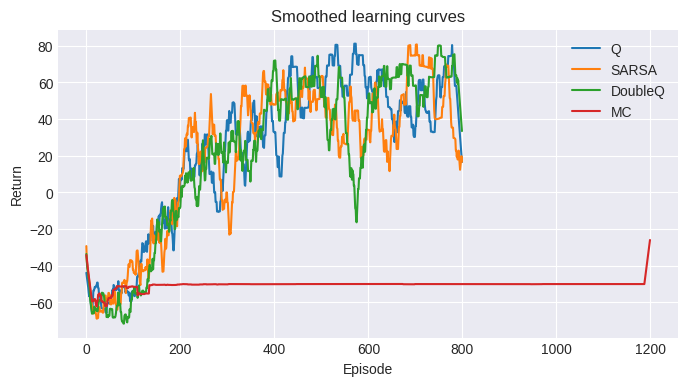

End events: goal goal goal drowned


In [11]:
# Cell 6: Quick experiment on a single grid to validate everything
N = 8
seed = 42

# map flood_choice from earlier to flood_mode string
mode_map = {"A":"global_rise","B":"bfs","C":"terrain_bfs","D":"stochastic"}
fmode = mode_map.get(flood_choice, "terrain_bfs")

env = FloodGridWorld(N, seed=seed, flood_mode=fmode,
                     water_rise_per_step=0.02, bfs_base_delay=1,
                     terrain_friction=0.6, random_delay_prob=0.15, rainfall_burst_prob=0.02,
                     bfs_sources=[(N-1,0)], max_steps=200)

print("Grid size:", N, "Flood mode:", fmode)
# train
Q_q, rew_q = train_q_learning(env, episodes=800, alpha=0.3, gamma=0.99, eps_start=1.0)
Q_sarsa, rew_sarsa = train_sarsa(env, episodes=800, alpha=0.3, gamma=0.99, eps_start=1.0)
Q_dq, rew_dq = train_double_q(env, episodes=800, alpha=0.3, gamma=0.99, eps_start=1.0)
Q_mc, rew_mc = train_monte_carlo(env, episodes=1200, gamma=0.99, eps_start=1.0)

# show learning curves
plt.figure(figsize=(8,4))
plt.plot(np.convolve(rew_q, np.ones(25)/25, mode='same'), label='Q')
plt.plot(np.convolve(rew_sarsa, np.ones(25)/25, mode='same'), label='SARSA')
plt.plot(np.convolve(rew_dq, np.ones(25)/25, mode='same'), label='DoubleQ')
plt.plot(np.convolve(rew_mc, np.ones(25)/25, mode='same'), label='MC')
plt.legend(); plt.title("Smoothed learning curves"); plt.xlabel("Episode"); plt.ylabel("Return")
plt.show()

# derive and display policies
pol_q, val_q = derive_policy_and_value(Q_q, env)
pol_s, val_s = derive_policy_and_value(Q_sarsa, env)
pol_dq, val_dq = derive_policy_and_value(Q_dq, env)
pol_mc, val_mc = derive_policy_and_value(Q_mc, env)

display(plot_policy(env, pol_q, title="Q-Learning policy"))
display(plot_policy(env, pol_s, title="SARSA policy"))
display(plot_policy(env, pol_dq, title="Double-Q policy"))
display(plot_policy(env, pol_mc, title="Monte Carlo policy"))

# simulate greedy and show trajectories
traj_q = simulate_greedy_episode(env, Q_q)
traj_s = simulate_greedy_episode(env, Q_sarsa)
traj_dq = simulate_greedy_episode(env, Q_dq)
traj_mc = simulate_greedy_episode(env, Q_mc)

display(plot_trajectory(env, traj_q, title="Q trajectory"))
display(plot_trajectory(env, traj_s, title="SARSA trajectory"))
display(plot_trajectory(env, traj_dq, title="DoubleQ trajectory"))
display(plot_trajectory(env, traj_mc, title="MC trajectory"))

print("End events:", traj_q[-1][1] if traj_q else None, traj_s[-1][1] if traj_s else None, traj_dq[-1][1] if traj_dq else None, traj_mc[-1][1] if traj_mc else None)


Running N= 5


MonteCarlo: 100%|██████████| 1500/1500 [00:00<00:00, 3488.78it/s]


Running N= 6


MonteCarlo: 100%|██████████| 1500/1500 [00:00<00:00, 7835.75it/s]


Running N= 7


MonteCarlo: 100%|██████████| 1500/1500 [00:00<00:00, 6196.92it/s]


Running N= 8


MonteCarlo: 100%|██████████| 1500/1500 [00:00<00:00, 3829.79it/s]


Running N= 9


MonteCarlo: 100%|██████████| 1500/1500 [00:00<00:00, 3490.40it/s]


Running N= 10


MonteCarlo: 100%|██████████| 1500/1500 [00:01<00:00, 1353.23it/s]


Running N= 11


MonteCarlo: 100%|██████████| 1500/1500 [00:00<00:00, 17113.23it/s]


Running N= 12


MonteCarlo: 100%|██████████| 1500/1500 [00:00<00:00, 12129.46it/s]


Running N= 13


MonteCarlo: 100%|██████████| 1500/1500 [00:00<00:00, 24107.04it/s]


Running N= 14


MonteCarlo: 100%|██████████| 1500/1500 [00:00<00:00, 18722.23it/s]


Running N= 15


MonteCarlo: 100%|██████████| 1500/1500 [00:00<00:00, 26007.96it/s]


Running N= 16


MonteCarlo: 100%|██████████| 1500/1500 [00:00<00:00, 23507.42it/s]


Running N= 17


MonteCarlo: 100%|██████████| 1500/1500 [00:00<00:00, 22312.74it/s]


Running N= 18


MonteCarlo: 100%|██████████| 1500/1500 [00:00<00:00, 31422.87it/s]


Running N= 19


MonteCarlo: 100%|██████████| 1500/1500 [00:00<00:00, 15758.50it/s]


Running N= 20


MonteCarlo: 100%|██████████| 1500/1500 [00:00<00:00, 27314.25it/s]


,N,Q_success,Q_drowned,SARSA_success,SARSA_drowned,DQ_success,DQ_drowned,MC_success,MC_drowned
0,5,0.000,0.315,0.900,0.100,0.920,0.080,0.89,0.11
1,6,0.945,0.055,0.000,0.320,0.880,0.120,0.86,0.14
2,7,0.865,0.135,0.925,0.075,0.895,0.105,0.90,0.10
3,8,0.890,0.110,0.890,0.110,0.865,0.135,0.86,0.14
4,9,0.815,0.185,0.865,0.135,0.000,0.450,0.89,0.11
5,10,0.840,0.160,0.820,0.180,0.000,0.520,0.00,0.48
6,11,0.805,0.195,0.805,0.195,0.825,0.175,0.00,1.00
7,12,0.795,0.205,0.000,0.570,0.840,0.160,0.00,1.00
8,13,0.785,0.215,0.000,0.500,0.000,0.580,0.00,1.00
9,14,0.000,0.650,0.000,0.670,0.000,0.650,0.00,1.00


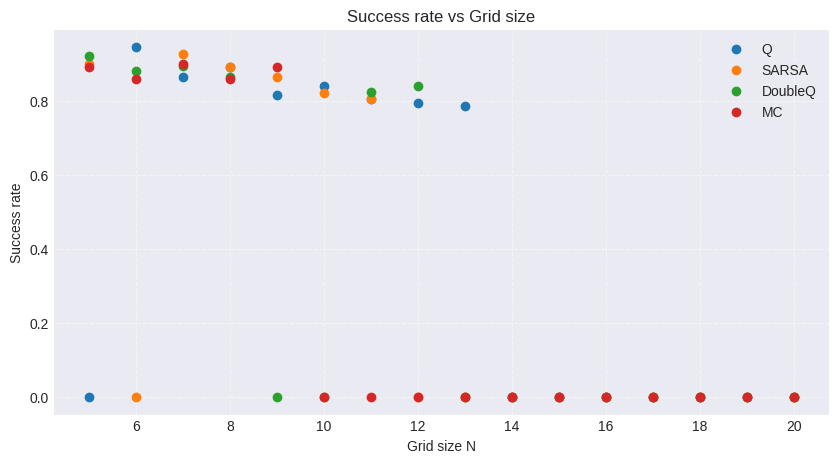

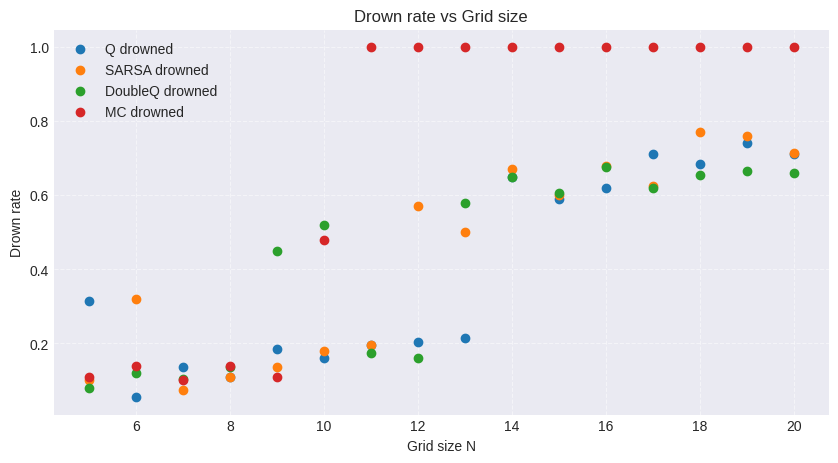

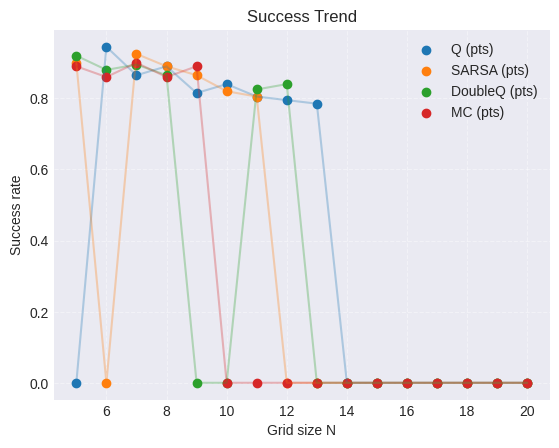

In [ ]:
# Cell 7: Grid-size sweep. For each grid size, reinitialize env, train Q & SARSA & DoubleQ & MC (shorter episodes), then evaluate success/drown/timeout over eval_episodes.
def evaluate_policy(env, Q, eval_episodes=200):
    success = drowned = timeout = 0
    for _ in range(eval_episodes):
        env.reset()
        s_idx = env.state_to_index(env._state())
        done=False
        while not done:
            ensure_Q_entry(Q, s_idx, 4)
            a = int(np.argmax(Q[s_idx]))
            state, r, done, info = env.step(a)
            s_idx = env.state_to_index(state)
        ev = info.get("event","")
        if ev == "goal":
            success += 1
        elif ev == "drowned":
            drowned += 1
        else:
            timeout += 1
    return {"success": success/eval_episodes, "drowned": drowned/eval_episodes, "timeout": timeout/eval_episodes}

grid_sizes = list(range(5, 21))
results = []
eval_episodes = 200

for N in grid_sizes:
    print("Running N=", N)
    env = FloodGridWorld(N, flood_mode=fmode, bfs_sources=[(N-1,0)], seed=42,
                         water_rise_per_step=0.02, bfs_base_delay=1, terrain_friction=0.6,
                         random_delay_prob=0.15, rainfall_burst_prob=0.02, max_steps=4*N)
    # train with fewer episodes for sweep (you can increase later)
    Q_q, _ = train_q_learning(env, episodes=1000, alpha=0.3, gamma=0.99, eps_start=1.0)
    Q_s, _ = train_sarsa(env, episodes=1000, alpha=0.3, gamma=0.99, eps_start=1.0)
    Q_dq, _ = train_double_q(env, episodes=1000, alpha=0.3, gamma=0.99, eps_start=1.0)
    Q_mc, _ = train_monte_carlo(env, episodes=1500, gamma=0.99, eps_start=1.0)
    # eval
    res_q = evaluate_policy(env, Q_q, eval_episodes)
    res_s = evaluate_policy(env, Q_s, eval_episodes)
    res_dq = evaluate_policy(env, Q_dq, eval_episodes)
    res_mc = evaluate_policy(env, Q_mc, eval_episodes)
    results.append({
        "N": N,
        "Q_success": res_q["success"], "Q_drowned": res_q["drowned"],
        "SARSA_success": res_s["success"], "SARSA_drowned": res_s["drowned"],
        "DQ_success": res_dq["success"], "DQ_drowned": res_dq["drowned"],
        "MC_success": res_mc["success"], "MC_drowned": res_mc["drowned"],
    })

df_results = pd.DataFrame(results)
display(df_results)
# Plot success rate vs grid size for each algorithm
plt.figure(figsize=(10,5))
plt.scatter(df_results.N, df_results.Q_success, label="Q")
plt.scatter(df_results.N, df_results.SARSA_success, label="SARSA")
plt.scatter(df_results.N, df_results.DQ_success, label="DoubleQ")
plt.scatter(df_results.N, df_results.MC_success, label="MC")
plt.xlabel("Grid size N")
plt.ylabel("Success rate")
plt.title("Success rate vs Grid size")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


# Plot drown rate
plt.figure(figsize=(10,5))
plt.scatter(df_results.N, df_results.Q_drowned, label="Q drowned")
plt.scatter(df_results.N, df_results.SARSA_drowned, label="SARSA drowned")
plt.scatter(df_results.N, df_results.DQ_drowned, label="DoubleQ drowned")
plt.scatter(df_results.N, df_results.MC_drowned, label="MC drowned")
plt.xlabel("Grid size N")
plt.ylabel("Drown rate")
plt.title("Drown rate vs Grid size")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()











Parameters grid and helpers

In [ ]:
# Cell A: parameter grids & helper functions for tuning
import itertools
from tqdm.notebook import tqdm

# Parameter grids: change values if you want a larger sweep
FLOOD_SPEEDS = [0.01, 0.02, 0.04]        # water_rise_per_step for global_rise
AGENT_SPEEDS = [1, 2]                    # how many micro-steps agent gets per env tick when evaluating
EPSILONS = [1.0, 0.5]                    # initial epsilon
EPS_DECAYS = [0.995, 0.99]               # epsilon decay per episode
ALPHAS = [0.1, 0.3]                      # learning rates
REWARD_SHAPES = [
    {"goal":100.0, "drown":-50.0, "step":-1.0},
    {"goal":20.0, "drown":-10.0, "step":-0.1}
]

# Which algorithms to tune
ALGOS = ["Q", "SARSA", "DoubleQ", "MC"]

# A safe wrapper to train an algorithm given selected params
def train_algo_with_params(algo_name, env, episodes, alpha, gamma, eps_start, eps_end, eps_decay):
    if algo_name == "Q":
        Q, rewards = train_q_learning(env, episodes=episodes, alpha=alpha, gamma=gamma,
                                      eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay)
    elif algo_name == "SARSA":
        Q, rewards = train_sarsa(env, episodes=episodes, alpha=alpha, gamma=gamma,
                                  eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay)
    elif algo_name == "DoubleQ":
        Q, rewards = train_double_q(env, episodes=episodes, alpha=alpha, gamma=gamma,
                                    eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay)
    elif algo_name == "MC":
        Q, rewards = train_monte_carlo(env, episodes=episodes, gamma=gamma,
                                       eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay)
    else:
        raise ValueError("Unknown algo")
    return Q, rewards


Tuning remover

In [ ]:
# Cell B: run parameter tuning (this can take time - lower episodes for quick runs)
def run_parameter_tuning(grid_sizes=[8], flood_speeds=FLOOD_SPEEDS, agent_speeds=AGENT_SPEEDS,
                         epsilons=EPSILONS, eps_decays=EPS_DECAYS, alphas=ALPHAS,
                         reward_shapes=REWARD_SHAPES, episodes_per_run=800, eval_episodes=200,
                         flood_mode=fmode, seed=42):
    rows = []
    total_runs = len(grid_sizes) * len(flood_speeds) * len(agent_speeds) * len(epsilons) * len(eps_decays) * len(alphas) * len(reward_shapes) * len(ALGOS)
    pbar = tqdm(total=total_runs, desc="Parameter tuning runs")

    for N in grid_sizes:
        for fs in flood_speeds:
            for aspeed in agent_speeds:
                for eps0 in epsilons:
                    for epsd in eps_decays:
                        for alpha in alphas:
                            for rshape in reward_shapes:
                                # initialize environment for this config (bfs/terrain mode preserved)
                                env = FloodGridWorld(N, flood_mode=flood_mode, bfs_sources=[(N-1,0)], seed=seed,
                                                     water_rise_per_step=fs, bfs_base_delay=1, terrain_friction=0.6,
                                                     random_delay_prob=0.15, rainfall_burst_prob=0.02, max_steps=4*N,
                                                     reward_goal=rshape["goal"], reward_drown=rshape["drown"], reward_step=rshape["step"])
                                for algo in ALGOS:
                                    # choose episodes: MC needs more episodes
                                    ep = episodes_per_run if algo != "MC" else max(episodes_per_run, int(episodes_per_run * 1.5))
                                    # train
                                    Q, _ = train_algo_with_params(algo, env,
                                                                  episodes=ep,
                                                                  alpha=alpha, gamma=0.99,
                                                                  eps_start=eps0, eps_end=0.05, eps_decay=epsd)
                                    # evaluate with agent speed: simulate 'aspeed' micro-steps per env tick
                                    success = drowned = timeout = 0
                                    for _ in range(eval_episodes):
                                        env.reset()
                                        done = False
                                        while not done:
                                            # choose greedy action
                                            sidx = env.state_to_index(env._state())
                                            ensure_Q_entry(Q, sidx, 4)
                                            a = int(np.argmax(Q[sidx]))
                                            # agent takes aspeed steps
                                            for _ in range(aspeed):
                                                state, r, done, info = env.step(a)
                                                if done: break
                                        ev = info.get("event","")
                                        if ev == "goal": success += 1
                                        elif ev == "drowned": drowned += 1
                                        else: timeout += 1
                                    rows.append({
                                        "grid_N": N, "flood_speed": fs, "agent_speed": aspeed,
                                        "eps_start": eps0, "eps_decay": epsd, "alpha": alpha,
                                        "reward_goal": rshape["goal"], "reward_drown": rshape["drown"], "reward_step": rshape["step"],
                                        "algo": algo,
                                        "success": success / eval_episodes, "drowned": drowned / eval_episodes, "timeout": timeout / eval_episodes
                                    })
                                    pbar.update(1)
    pbar.close()
    return pd.DataFrame(rows)

# Example (quick) run: small sweep to test
tune_df_quick = run_parameter_tuning(grid_sizes=[5,6,7,8,9,10,11,12,13,15,16], flood_speeds=[0.02,0.04], agent_speeds=[1,2],
                                     epsilons=[1.0,0.5], eps_decays=[0.995], alphas=[0.1,0.3],
                                     reward_shapes=REWARD_SHAPES, episodes_per_run=500, eval_episodes=100, flood_mode=fmode)
display(tune_df_quick.head())



Parameter tuning runs:   0%|          | 0/1408 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Q-Learning: 100%|██████████| 500/500 [00:00<00:00, 1081.19it/s]

SARSA: 100%|██████████| 500/500 [00:00<00:00, 1182.75it/s]

Double-Q: 100%|██████████| 500/500 [00:00<00:00, 907.36it/s]

MonteCarlo: 100%|██████████| 750/750 [00:00<00:00, 30763.86it/s]

Q-Learning: 100%|██████████| 500/500 [00:00<00:00, 1018.08it/s]

SARSA: 100%|██████████| 500/500 [00:00<00:00, 1122.56it/s]

Double-Q: 100%|██████████| 500/500 [00:00<00:00, 893.82it/s]

MonteCarlo: 100%|██████████| 750/750 [00:00<00:00, 967.48it/s]

Q-Learning: 100%|██████████| 500/500 [00:00<00:00, 1119.49it/s]

SARSA: 100%|██████████| 500/500 [00:00<00:00, 1223.96it/s]

Double-Q: 100%|██████████| 500/500 [00:00<00:00, 958.45it/s]

MonteCarlo: 100%|██████████| 750/750 [00:00<00:00, 1150.88it/s]

Q-Learning: 100%|██████████| 500/500 [00:00<00:00, 1339.46it/s]

SARSA: 100%|██████████| 500/500 [00:00<00:00, 928.13it/s]

Double-Q: 100%|██████████| 500/500 [00:00<00:00, 785.29it/s]

MonteCa

,grid_N,flood_speed,agent_speed,eps_start,eps_decay,alpha,reward_goal,reward_drown,reward_step,algo,success,drowned,timeout
0,5,0.02,1,1.0,0.995,0.1,100.0,-50.0,-1.0,Q,0.90,0.10,0.0
1,5,0.02,1,1.0,0.995,0.1,100.0,-50.0,-1.0,SARSA,0.91,0.09,0.0
2,5,0.02,1,1.0,0.995,0.1,100.0,-50.0,-1.0,DoubleQ,0.91,0.09,0.0
3,5,0.02,1,1.0,0.995,0.1,100.0,-50.0,-1.0,MC,0.91,0.09,0.0
4,5,0.02,1,1.0,0.995,0.1,20.0,-10.0,-0.1,Q,0.91,0.09,0.0


Quick tuning saved to tuning_quick_results.csv


Bar Graph comparing best parameter

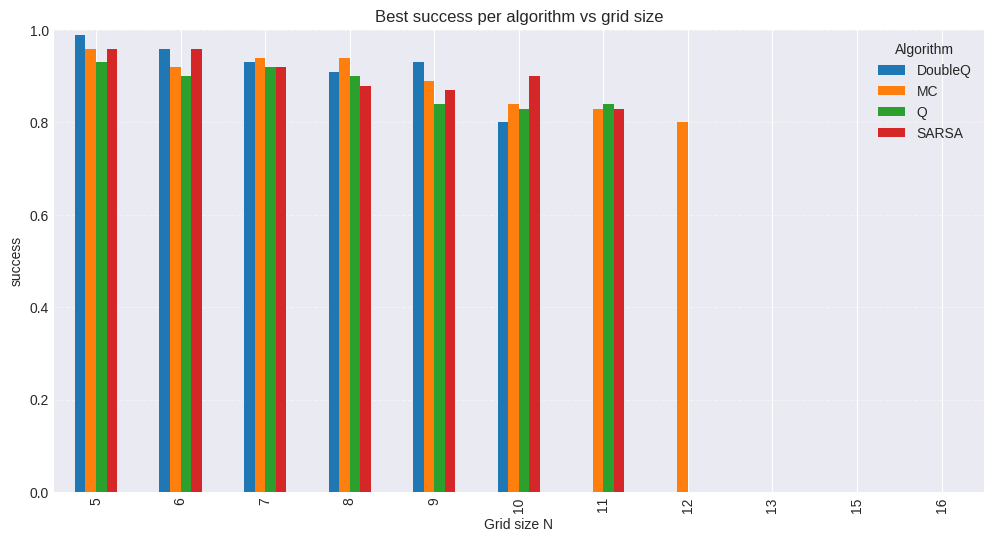

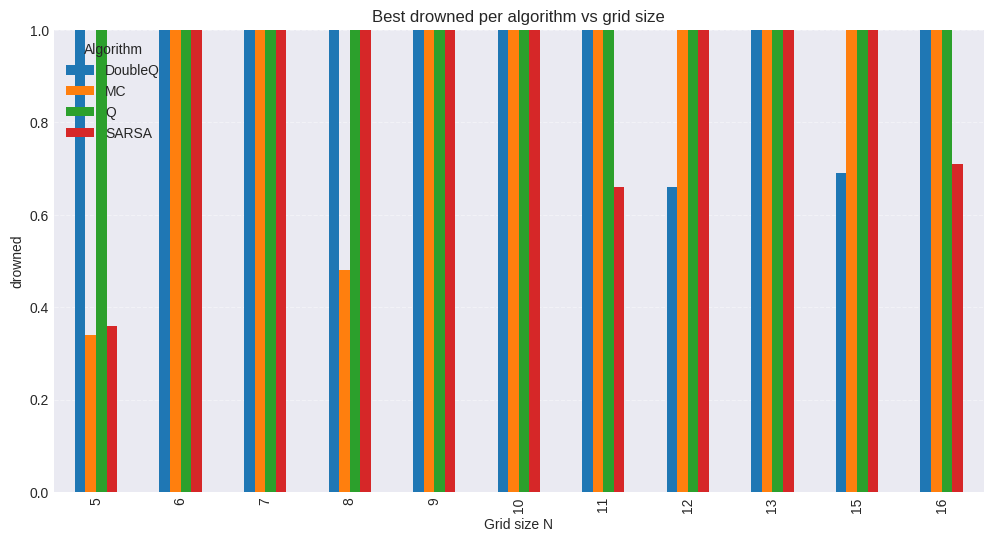

In [ ]:
# Cell C: Summarize tuning_df and plot bar charts
def plot_tuning_summary(tuning_df, metric="success", groupby=["algo","grid_N"], top_k=1):
    # We'll show for each algorithm the best (max metric) configuration per grid_N
    bests = tuning_df.sort_values(metric, ascending=False).groupby(["algo","grid_N"]).first().reset_index()
    # create pivot for plotting: rows=grid_N columns=algo
    pivot = bests.pivot(index="grid_N", columns="algo", values=metric)
    pivot = pivot.sort_index()
    pivot.plot(kind="bar", figsize=(12,6))
    plt.title(f"Best {metric} per algorithm vs grid size")
    plt.xlabel("Grid size N")
    plt.ylabel(metric)
    plt.ylim(0,1.0)
    plt.legend(title="Algorithm")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.show()

# Use the tuning results (for quick run use tune_df_quick)
plot_tuning_summary(tune_df_quick, metric="success")
# Also show drown comparison
plot_tuning_summary(tune_df_quick, metric="drowned")


In [28]:
# Cell 8: Parameter sensitivity. Sweeps flood speed & agent "speed" (we model agent speed by letting agent take extra moves per environment flood tick)
def run_sensitivity(N=10, flood_speeds=[0.01,0.02,0.04], agent_speeds=[1,2], epsilons=[0.2,0.5,1.0], episodes=1200):
    rows=[]
    for fs in flood_speeds:
        for aspeed in agent_speeds:
            for eps in epsilons:
                env = FloodGridWorld(N, flood_mode=fmode, bfs_sources=[(N-1,0)], seed=42,
                                     water_rise_per_step=fs, bfs_base_delay=1, terrain_friction=0.6,
                                     random_delay_prob=0.15, rainfall_burst_prob=0.02, max_steps=200)
                # custom wrapper: when evaluating, agent moves 'aspeed' times per step (simulate fast agent). For training we'll keep standard but during eval apply speed.
                Q_q, _ = train_q_learning(env, episodes=episodes, alpha=0.3, gamma=0.99, eps_start=eps)
                # Evaluate with agent speed
                success = drowned = timeout = 0
                eval_episodes=200
                for _ in range(eval_episodes):
                    env.reset()
                    done=False
                    s = env._state()
                    s_idx = env.state_to_index(s)
                    while not done:
                        ensure_Q_entry(Q_q, s_idx, 4)
                        a = int(np.argmax(Q_q[s_idx]))
                        # agent performs 'aspeed' micro-actions before environment flood step is applied:
                        for _ in range(aspeed):
                            ns, r, done, info = env.step(a)
                            s_idx = env.state_to_index(ns)
                            if done:
                                break
                        # if not done, loop continues; flood already advanced inside env.step
                    ev = info.get("event","")
                    if ev=="goal": success += 1
                    elif ev=="drowned": drowned += 1
                    else: timeout += 1
                rows.append({"flood_speed": fs, "agent_speed": aspeed, "eps_start": eps,
                             "success": success/ eval_episodes, "drowned": drowned/ eval_episodes, "timeout": timeout/ eval_episodes})
                print("fs",fs,"as",aspeed,"eps",eps,"=> success",rows[-1]["success"])
    return pd.DataFrame(rows)

sensitivity_df = run_sensitivity(N=12, flood_speeds=[0.01, 0.02, 0.04], agent_speeds=[1,2], epsilons=[0.5,1.0], episodes=800)
display(sensitivity_df)


Q-Learning: 100%|██████████| 800/800 [00:00<00:00, 989.29it/s] 


fs 0.01 as 1 eps 0.5 => success 0.76


Q-Learning: 100%|██████████| 800/800 [00:00<00:00, 1263.64it/s]


fs 0.01 as 1 eps 1.0 => success 0.79


Q-Learning: 100%|██████████| 800/800 [00:00<00:00, 1033.18it/s]


fs 0.01 as 2 eps 0.5 => success 0.0


Q-Learning: 100%|██████████| 800/800 [00:00<00:00, 1232.89it/s]


fs 0.01 as 2 eps 1.0 => success 0.755


Q-Learning: 100%|██████████| 800/800 [00:00<00:00, 1007.73it/s]


fs 0.02 as 1 eps 0.5 => success 0.76


Q-Learning: 100%|██████████| 800/800 [00:00<00:00, 1296.04it/s]


fs 0.02 as 1 eps 1.0 => success 0.79


Q-Learning: 100%|██████████| 800/800 [00:00<00:00, 951.54it/s] 


fs 0.02 as 2 eps 0.5 => success 0.0


Q-Learning: 100%|██████████| 800/800 [00:00<00:00, 1251.80it/s]


fs 0.02 as 2 eps 1.0 => success 0.755


Q-Learning: 100%|██████████| 800/800 [00:00<00:00, 1112.64it/s]


fs 0.04 as 1 eps 0.5 => success 0.76


Q-Learning: 100%|██████████| 800/800 [00:00<00:00, 1331.71it/s]


fs 0.04 as 1 eps 1.0 => success 0.79


Q-Learning: 100%|██████████| 800/800 [00:01<00:00, 573.33it/s]


fs 0.04 as 2 eps 0.5 => success 0.0


Q-Learning: 100%|██████████| 800/800 [00:00<00:00, 847.86it/s] 


fs 0.04 as 2 eps 1.0 => success 0.755


,flood_speed,agent_speed,eps_start,success,drowned,timeout
0,0.01,1,0.5,0.760,0.240,0.00
1,0.01,1,1.0,0.790,0.210,0.00
2,0.01,2,0.5,0.000,0.990,0.01
3,0.01,2,1.0,0.755,0.245,0.00
4,0.02,1,0.5,0.760,0.240,0.00
5,0.02,1,1.0,0.790,0.210,0.00
6,0.02,2,0.5,0.000,0.990,0.01
7,0.02,2,1.0,0.755,0.245,0.00
8,0.04,1,0.5,0.760,0.240,0.00
9,0.04,1,1.0,0.790,0.210,0.00
